In [1]:
import os
from tqdm import tqdm
import geopandas as gpd
import numpy as np
import pandas as pd

from enum import Enum

from FrontierExploration.preprocessing.layout.polygons import Square


base_dir = os.getcwd()
files_dir = f"{base_dir}/files"
file_dir = f"{files_dir}/small_house_clean.dxf"

def get_center(item):
    xmin, ymin, xmax, ymax = item["geometry"].bounds
    return pd.Series([(xmax+xmin)/2, (ymax+ymin)/2, int(item["intersects"])], index=['axis_x', 'axis_y', 'occuped'])

In [10]:
class BlockStatus(Enum):
    Free = 0
    Occuped = 1
    Unknown = 2

polygons_list = []
square_size = 1
layout = gpd.read_file(file_dir)
clean_layout = layout['geometry']
xmin, ymin, xmax, ymax = clean_layout.total_bounds
for xstart in np.nditer(np.arange(int(xmin) - square_size, int(xmax), square_size)):
    for ystart in  np.nditer(np.arange(int(ymin) - square_size, int(ymax), square_size)):
        polygons_list.append(Square(square_size, xstart, ystart))

layout_df = gpd.GeoDataFrame(geometry=polygons_list)
layout_df["intersects"]= layout_df.intersects(clean_layout.unary_union)
layout_df.loc[layout_df["intersects"] == True, "status"] = BlockStatus.Occuped.value
layout_df.loc[layout_df["intersects"] == False, "status"] = BlockStatus.Unknown.value

<AxesSubplot:>

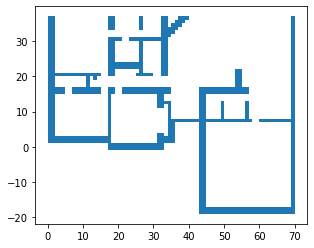

In [17]:
layout_df.loc[layout_df["status"] == BlockStatus.Occuped.value].plot()

In [108]:
from shapely.geometry import Polygon, LineString, Point, MultiLineString, MultiPolygon

class RayCast:
    def __init__(self, num_rays: int, ray_range: float, start_x: float = 0, start_y: float = 0):
        self.start_x = start_x
        self.start_y = start_y
        self._num_rays = num_rays
        self._ray_range = ray_range
        self.raycast_df = gpd.GeoDataFrame(geometry=[LineString([(start_x, start_y), movement]) for movement in self.directions])

    def run_on_df(self, layout_df: gpd.GeoDataFrame):
        for index in tqdm(layout_df.index):
            raycast.intersect_with_polygon(layout_df['geometry'][index],layout_df['status'][index])
        
            
    def intersect_with_polygon(self, polygon: Polygon, block_status: BlockStatus):
        if block_status == BlockStatus.Occuped.value:
            self.raycast_df["geometry"] = self.raycast_df["geometry"].apply(self.get_line_to_intersection, args=(polygon,))
        if block_status == BlockStatus.Free.value:
            poly_df = gpd.GeoDataFrame(geometry=[poly])
            self.raycast_df["geometry"] = self.raycast_df.overlay(poly_df, how='difference')["geometry"]
    
    def get_line_to_intersection(self, line: LineString, polygon: Polygon):
        origin = self.origin_point
        if line.intersects(polygon):
            lines_distances = {}
            for point in line.intersection(polygon).coords:
                line = LineString([origin,point])
                lines_distances[line.length] = line
            shorter = lines_distances[min(lines_distances.keys())] if len(lines_distances)!=0 else line
        else:
            shorter = line
        return shorter        

    @property
    def visibility_percentage(self):
        return 100*self.visibility/self._ray_range
    
    @property
    def visibility(self):
        self.raycast_df['length'] = self.raycast_df.apply(lambda row: row[0].length, axis=1)
        return self.raycast_df['length'].mean()
    
    @property
    def origin_point(self):
        return Point(self.start_x, self.start_y)
    
    @property
    def directions(self):
        return [(self._ray_range*np.cos(angle)+self.start_x, self._ray_range*np.sin(angle)+self.start_y) for angle in np.linspace(0, 2 * np.pi, num=self._num_rays, endpoint=False)]

    def plot(self, *args, **kwargs):
        self.raycast_df.plot( *args, **kwargs)

In [109]:
# circle = Point(2, 2).buffer(0.5)
# poly = Polygon([(1.5,1.5),(1.5,2),(2,2),(4,2),(4,1.5)])
# raycast.intersect_with_polygon(circle, BlockStatus.Occuped.value)
# raycast.plot()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3976/3976 [00:01<00:00, 2776.89it/s]


78.85710030409845


<AxesSubplot:>

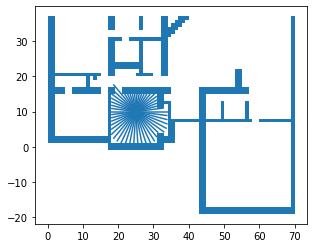

In [116]:
raycast = RayCast(num_rays=50, ray_range=10, start_x=25, start_y=10)
raycast.run_on_df(layout_df)
print(raycast.visibility_percentage)
raycast.raycast_df.append(layout_df.loc[layout_df["status"]==BlockStatus.Occuped.value]).plot()